The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 循环神经网络的简洁实现
:label:`sec_rnn-concise`

虽然 :numref:`sec_rnn_scratch`
对了解循环神经网络的实现方式具有指导意义，但并不方便。
本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。
我们仍然从读取时光机器数据集开始。


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。
事实上，我们还没有讨论多层循环神经网络的意义（这将在 :numref:`sec_deep_rnn`中介绍）。
现在仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


In [2]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

In [3]:
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：
它是指每个时间步的隐状态，这些隐状态可以用作后续输出层的输入。


In [4]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

与 :numref:`sec_rnn_scratch`类似，
[**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**]。
注意，`rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [5]:
#@save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # rnn返回两个以上的值
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [6]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

d2l.predict_ch8('time traveller', 10, net, vocab)

'time travellerg<unk>spxqpzqq'

很明显，这种模型根本不能输出好的结果。
接下来，我们使用 :numref:`sec_rnn_scratch`中
定义的超参数调用`train_ch8`，并且[**使用高级API训练模型**]。


perplexity 1.4, 16226.0 tokens/sec on /GPU:0


time traveller for so it wisc beep choverably gone wimont of the


traveller for so it wisc wey cond redtreasterint bug thing 


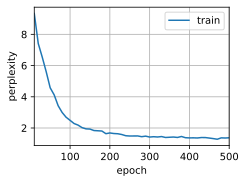

In [7]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，
该模型在较短的时间内达到了较低的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，我们还需要计算整个模型的输出层。
* 相比从零开始实现的循环神经网络，使用高级API实现可以加速训练。

## 练习

1. 尝试使用高级API，能使循环神经网络模型过拟合吗？
1. 如果在循环神经网络模型中增加隐藏层的数量会发生什么？能使模型正常工作吗？
1. 尝试使用循环神经网络实现 :numref:`sec_sequence`的自回归模型。


[Discussions](https://discuss.d2l.ai/t/5766)
